### Importing Libraries

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Color

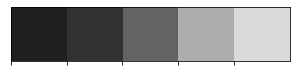

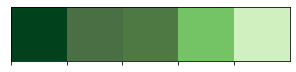

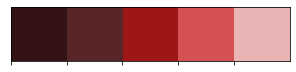

In [27]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

### Data Preparation

In [29]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [30]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('C:/Users/Welcome/Machine Learning Assignments/Brain_Tumor','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('C:/Users/Welcome/Machine Learning Assignments/Brain_Tumor','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:03<00:00, 24.60it/s]


In [31]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [32]:
X_train.shape

(3264, 150, 150, 3)

Dividing the dataset into Training and Testing sets.

In [33]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Performing One Hot Encoding on the labels after converting it into numerical values:

In [34]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [35]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 23s 1us/step


In [36]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 150, 150, 3)  0           ['normalization[0][0]']      

 block2b_expand_conv (Conv2D)   (None, 38, 38, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 38, 38, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 38, 38, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2b_dwconv (DepthwiseConv2  (None, 38, 38, 144)  1296       ['block2b_expand_activation[0][0]
 D)                                                              ']                               
          

                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 19, 19, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 19, 19, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_activation (Activation  (None, 19, 19, 240)  0          ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_s

 block4b_activation (Activation  (None, 10, 10, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     
                                                                                                  
 block4b_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block4b_se_reshape[0][0]']     
                                                                                                  
 block4b_s

                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_se_excite (Multiply)   (None, 10, 10, 480)  0           ['block5a_activation[0][0]',     
                                                                  'block5a_se_expand[0][0]']      
                                                                                                  
 block5a_p

 block5c_project_conv (Conv2D)  (None, 10, 10, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 10, 10, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 10, 10, 112)  0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_add (Add)              (None, 10, 10, 112)  0           ['block5c_drop[0][0]',           
                                                                  'block5b_add[0][0]']            
                                                                                                  
 block6a_e

 block6b_add (Add)              (None, 5, 5, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 5, 5, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 5, 5, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6c_expand_activation (Act  (None, 5, 5, 1152)  0           ['block6c_expand_bn[0][0]']      
 ivation)                                                                                         
          

 block7a_expand_bn (BatchNormal  (None, 5, 5, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 5, 5, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 5, 5, 1152)  10368       ['block7a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block7a_bn (BatchNormalization  (None, 5, 5, 1152)  4608        ['block7a_dwconv[0][0]']         
 )        

### Model Compilation

In [38]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [40]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

### Training the Model

In [41]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.4765 - accuracy: 0.8233
Epoch 1: val_accuracy improved from -inf to 0.89456, saving model to effnet.h5
83/83 [==============================] - 691s 7s/step - loss: 0.4765 - accuracy: 0.8233 - val_loss: 0.3643 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.1905 - accuracy: 0.9311
Epoch 2: val_accuracy did not improve from 0.89456
83/83 [==============================] - 512s 6s/step - loss: 0.1905 - accuracy: 0.9311 - val_loss: 0.4990 - val_accuracy: 0.8639 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.1591 - accuracy: 0.9455
Epoch 3: val_accuracy improved from 0.89456 to 0.92177, saving model to effnet.h5
83/83 [==============================] - 453s 5s/step - loss: 0.1591 - accuracy: 0.9455 - val_loss: 0.2860 - val_accuracy: 0.9218 - lr: 0.0010
Epoch 4/12
83/83 [==============================] - ETA: 0s - loss: 0.0924 - 

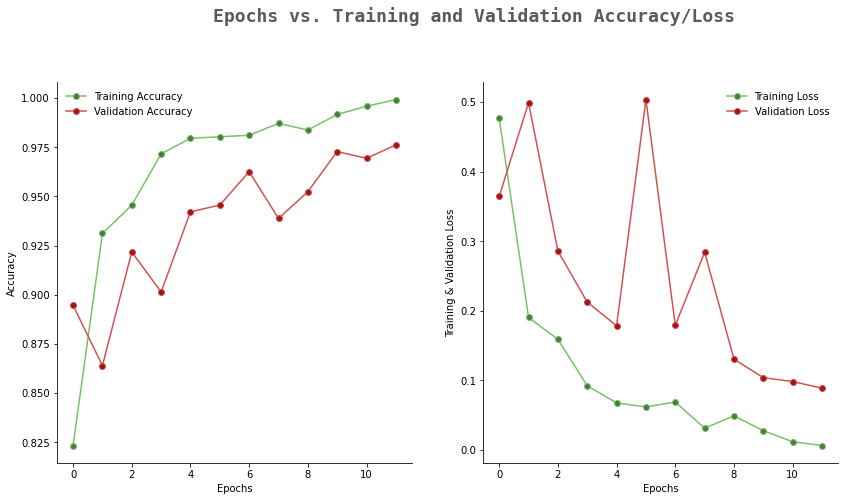

In [43]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

### Prediction

In [44]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 22s 1s/step


### Evaluation

In [45]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96        93
           1       0.94      1.00      0.97        51
           2       0.95      0.98      0.96        96
           3       0.99      0.98      0.98        87

    accuracy                           0.97       327
   macro avg       0.97      0.97      0.97       327
weighted avg       0.97      0.97      0.97       327



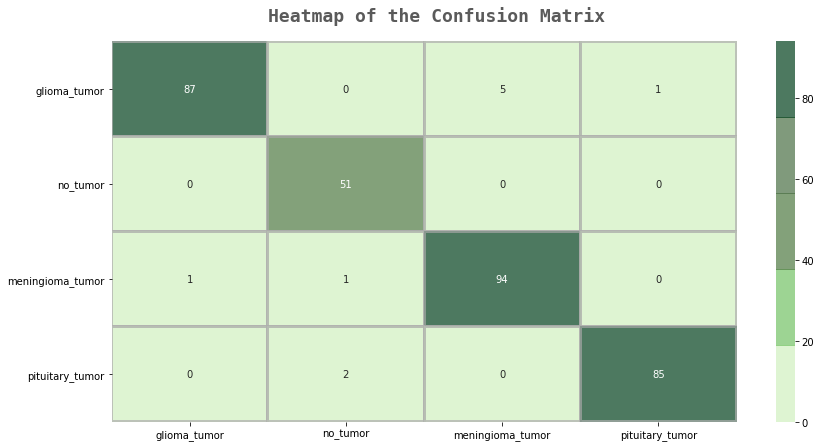

In [46]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [47]:
model.save("braintumor.h5")